In [1]:
path = "Data/All_Records_Clean_Names.csv"

In [2]:
from TFIDF_Sim_Utils import (ngrams,
                             awesome_cossim_top,
                             get_matches_df)
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import time

ModuleNotFoundError: No module named 'ftfy'

In [6]:
df = pd.read_csv(path)

In [8]:
df.sample(n=4)

,Internal ID,Name,Created Date,Sectors,Clean_Name
629989,432720,ZimVie Inc.,2022-10-10 01:55:02.368,Furniture; other manufactured goods n.e.c.|Med...,Zimvie
124109,507818,CHUBB FIRE & SECURITY PTY LTD,2022-11-28 13:55:42.150,Public administration and defence services; co...,Chubb Fire & Security
479114,296652,SCENTRE GROUP BRANDSPACE (WEST LAKES),2021-06-07 00:00:00.000,Real estate services,Scentre Group Brandspace
10416,73660,ACCENTURE PUBLIC LIMITED COMPANY,2022-05-03 00:00:00.000,Computer and related services|Other business s...,Accenture Public Company


# Create TFIDF Vectors

In [10]:
company_names = df["Clean_Name"].astype(str)
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(company_names)

# Create Matches Matrix

In [11]:

t1 = time.time()
matches = awesome_cossim_top(tf_idf_matrix, tf_idf_matrix.transpose(), 100, 0.9)
t = time.time()-t1
print("TIME TAKEN:", t)

TIME TAKEN: 477.8784010410309


# Create Data Structure

In [13]:
t1 = time.time()

ID_matches_dict = {}
for ID in df["Internal ID"]:
    ID_matches_dict[ID] = []

matches_dict = {}
for ID in df["Internal ID"]:
    matches_dict[ID] = []

non_zeros = matches.nonzero()
sparserows = non_zeros[0]
sparsecols = non_zeros[1]
nr_matches = sparsecols.size

for index in range(0, nr_matches):
    left_name = df["Internal ID"][sparserows[index]]
    right_name = df["Internal ID"][sparsecols[index]]
    similarity = matches.data[index]

    ID_matches_dict[left_name].append(right_name)
    ID_matches_dict[right_name].append(left_name)

t = time.time()-t1
print("TIME TAKEN:", t)

TIME TAKEN: 126.73844885826111


In [19]:
mdf = pd.DataFrame(list(ID_matches_dict.items()), columns=['Internal ID', 'Matches'])

In [20]:
df.shape

(631829, 5)

In [21]:
mdf.shape

(631829, 2)

In [23]:
result = df.merge(mdf, on="Internal ID")

In [28]:
## need to remove the Internal ID's occurring in their own row.
result['Matches'] = result.apply(lambda row: [id for id in row['Matches'] if id != row['Internal ID']], axis=1)

In [59]:
def remove_duplicates(lst):
    return list(dict.fromkeys(lst))

In [ ]:
len(result["Matches"][1])

In [71]:
# need to remove duplicates occurring in the Matches
result["Matches"] = result["Matches"].apply(remove_duplicates)

In [72]:
len(result["Matches"][1])

69

In [73]:
# result.to_excel("matching_results.xlsx", index=False)

# Inspect matches

In [180]:
def get_rows_by_ids(df, id_list):
    return df[df['Internal ID'].isin(id_list)]

def inspect_matches(df, internal_id):
    id_list = list(df[df["Internal ID"] == internal_id]["Matches"])[0]
    matching_names = get_rows_by_ids(df, id_list)["Name"]
    print(df[df["Internal ID"] == internal_id]["Name"])
    print()
    print("MATCHES:")
    print(matching_names)
    return matching_names

#### Randomly Sample a Row and Observe its Matches

In [249]:
ID = result.sample(n=1)["Internal ID"].values[0]
m = inspect_matches(result, ID)

455795    Reflektive, Inc.
Name: Name, dtype: object

MATCHES:
455785    Reflektive, Inc.
455786    Reflektive, Inc.
455787    Reflektive, Inc.
455788    Reflektive, Inc.
455789    Reflektive, Inc.
455790    Reflektive, Inc.
455791    Reflektive, Inc.
455792    Reflektive, Inc.
455793    Reflektive, Inc.
455794    Reflektive, Inc.
Name: Name, dtype: object


# Unique Names for testing with FastText word representations

In [51]:
my_list = list(set(result["Clean_Name"].astype(str).tolist()))

In [54]:
len(my_list)

119789

In [52]:
# Open the file in write mode
with open('comp_names.txt', 'w') as f:
    # Join the list elements with newline character and write to the file
    f.write('\n'.join(my_list))


# Create Adjacency List for SBM

In [119]:

# Create an adjacency list as a list of tuples
adjacency_list = [(single, item) for single, row_list in zip(result['Internal ID'], result['Matches']) for item in row_list]
#print(adjacency_list)


In [120]:
print(len(adjacency_list))

17627472


In [121]:
# Convert tuples to frozensets to handle order-insensitive duplicates
frozen_adjacency_list = [frozenset(pair) for pair in adjacency_list]

# Use a set to remove duplicates
unique_frozen_adjacency_list = set(frozen_adjacency_list)

# Convert frozensets back to tuples to get the final unique adjacency list
unique_adjacency_list = [tuple(pair) for pair in unique_frozen_adjacency_list]


In [122]:
print(len(unique_adjacency_list))

8813736


In [123]:
unique_adjacency_list[0]

(521019, 491707)

In [124]:
import pickle

def pickle_adjacency_list(adjacency_list, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(adjacency_list, file)

file_path = 'adjacency_list.pkl'

pickle_adjacency_list(unique_adjacency_list, file_path)


In [129]:
def find_disconnected_components(adjacency_list):
    # Convert the list of tuples to a dictionary representation
    graph = {}
    for node1, node2 in adjacency_list:
        graph.setdefault(node1, []).append(node2)
        graph.setdefault(node2, []).append(node1)

    def dfs(node):
        visited.add(node)
        component.append(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                dfs(neighbor)

    visited = set()
    disconnected_components = []

    for node in graph:
        if node not in visited:
            component = []
            dfs(node)
            disconnected_components.append(component)

    return disconnected_components



Trying on smaller example

In [149]:
adj_list = unique_adjacency_list

In [150]:
DCs = find_disconnected_components(adj_list)

In [185]:
len(DCs[0])

33

In [151]:
len(DCs)

73826

In [157]:
len(DCs[840])

154

In [158]:
count = 0
for i in range(len(DCs)):
    count+=len(DCs[i])

print(count)

591341


In [186]:
result.shape

(631829, 6)

### We want to check that the missing count is explained by our nodes that have no matches.

In [187]:
631829 - 591341

40488

In [189]:
num_empty_lists = result['Matches'].apply(lambda x: len(x) == 0).sum()
print(num_empty_lists)

40488


In [197]:
assert 631829 - 591341 == num_empty_lists

# Create Group IDs

In [30]:
Group_ID_dictionary = {}

In [213]:
Group_ID = int(0)

for CC in DCs:

    Group_ID_dictionary[Group_ID] = CC
    Group_ID += int(1)


In [214]:
group_dict = {group_id: internal_ids for group_id, internal_ids in Group_ID_dictionary.items()}
flattened_dict = {internal_id: group_id for group_id, internal_ids in group_dict.items() for internal_id in internal_ids}


In [215]:
result['Group_ID'] = result['Internal ID'].map(flattened_dict)


In [216]:
result

,Internal ID,Name,Created Date,Sectors,Clean_Name,Matches,Group_ID
0,333317,NaN,2022-09-13 23:13:53.907,"Lead, zinc and tin ores and concentrates",Nan,"[34709, 34523, 34453, 36680, 665030, 35188, 14...",136
1,333316,NaN,2022-09-13 23:13:53.907,Computer and related services,Nan,"[333317, 34709, 34523, 34453, 36680, 665030, 3...",136
2,333315,NaN,2022-09-13 23:13:53.907,Aviation Gasoline,Nan,"[333317, 333316, 34709, 34523, 34453, 36680, 6...",136
3,333314,NaN,2022-09-13 23:13:53.907,"Ash for treatment, Re-processing of ash into c...",Nan,"[333317, 333316, 333315, 34709, 34523, 34453, ...",136
4,333313,NaN,2022-09-13 23:13:53.907,Aviation Gasoline,Nan,"[333317, 333316, 333315, 333314, 34709, 34523,...",136
...,...,...,...,...,...,...,...
631824,169379,ZYNGA INC.,2021-08-11 00:00:00.000,"Computer and related services|Recreational, cu...",Zynga,"[57358, 89401, 268934, 210854, 145661]",21097
631825,145661,ZYNGA INC.,2022-05-05 00:00:00.000,"Recreational, cultural and sporting services|C...",Zynga,"[57358, 89401, 268934, 169379, 210854]",21097
631826,210854,ZYNGA INC.,2022-05-03 00:00:00.000,"Computer and related services|Recreational, cu...",Zynga,"[57358, 89401, 268934, 169379, 145661]",21097
631827,269849,ZZZ Meats Pty Ltd,2022-06-26 00:00:00.000,Meat products nec,Zzz Meats,[],NaN


# Adding Group IDs for the No Matches as well

In [220]:
result["Group_ID"].astype(float).max()

73825.0

In [221]:
starting_ID = result["Group_ID"].astype(float).max() + 1

In [222]:
starting_ID

73826.0

In [224]:
df_nan = result[result['Group_ID'].isnull()]

In [228]:
rows = df_nan.shape[0]
G_ids = []
for i in range(rows):
    G_ids.append(starting_ID)
    starting_ID += 1

In [232]:
df_nan["Group_ID"] = G_ids
df_nan["Group_ID"] = df_nan["Group_ID"].astype(float)

/var/folders/2v/wnvclmc50p7dm25wgtwp72jr0000gn/T/ipykernel_4439/2378012856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["Group_ID"] = G_ids
/var/folders/2v/wnvclmc50p7dm25wgtwp72jr0000gn/T/ipykernel_4439/2378012856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["Group_ID"] = df_nan["Group_ID"].astype(float)


In [233]:
df_nan

,Internal ID,Name,Created Date,Sectors,Clean_Name,Matches,Group_ID
10,749047,‚á•BPM PROJECTS PTY LTD,2023-06-21 09:14:26.201,NaN,Bpm Projects,[],73826.0
11,749057,‚á•CALUTIONS PTY LTD,2023-06-21 09:14:26.201,NaN,Calutions,[],73827.0
16,749060,‚á•GARDEX PTY LTD,2023-06-21 09:14:26.201,NaN,Gardex,[],73828.0
17,749064,‚á•HEATH MOTOR GROUP PTY LTD,2023-06-21 09:14:26.201,NaN,Heath Motor Group,[],73829.0
20,749051,‚á•The Trustee for The S & H McBride Family Trust,2023-06-21 09:14:26.201,NaN,The Trustee For The S & H Mcbride Family Trust,[],73830.0
...,...,...,...,...,...,...,...
631818,81197,Zylux Distribution Pty Ltd,2021-09-30 00:00:00.000,"Wholesale trade and commission trade services,...",Zylux Distribution,[],114309.0
631819,747885,Zymeworks Inc,2023-06-20 00:42:03.253,Health and social work services,Zymeworks,[],114310.0
631820,113001,ZYNGA INC - CL A USD 0.000006,2022-06-30 00:00:00.000,"Computer and related services|Recreational, cu...",Zynga Cl A Usd,[],114311.0
631827,269849,ZZZ Meats Pty Ltd,2022-06-26 00:00:00.000,Meat products nec,Zzz Meats,[],114312.0


In [238]:
Removed_nan_df = result.dropna(subset=['Group_ID'])

In [239]:
FINAL_DF = pd.concat([Removed_nan_df, df_nan])

In [240]:
FINAL_DF

,Internal ID,Name,Created Date,Sectors,Clean_Name,Matches,Group_ID
0,333317,NaN,2022-09-13 23:13:53.907,"Lead, zinc and tin ores and concentrates",Nan,"[34709, 34523, 34453, 36680, 665030, 35188, 14...",136
1,333316,NaN,2022-09-13 23:13:53.907,Computer and related services,Nan,"[333317, 34709, 34523, 34453, 36680, 665030, 3...",136
2,333315,NaN,2022-09-13 23:13:53.907,Aviation Gasoline,Nan,"[333317, 333316, 34709, 34523, 34453, 36680, 6...",136
3,333314,NaN,2022-09-13 23:13:53.907,"Ash for treatment, Re-processing of ash into c...",Nan,"[333317, 333316, 333315, 34709, 34523, 34453, ...",136
4,333313,NaN,2022-09-13 23:13:53.907,Aviation Gasoline,Nan,"[333317, 333316, 333315, 333314, 34709, 34523,...",136
...,...,...,...,...,...,...,...
631818,81197,Zylux Distribution Pty Ltd,2021-09-30 00:00:00.000,"Wholesale trade and commission trade services,...",Zylux Distribution,[],114309.0
631819,747885,Zymeworks Inc,2023-06-20 00:42:03.253,Health and social work services,Zymeworks,[],114310.0
631820,113001,ZYNGA INC - CL A USD 0.000006,2022-06-30 00:00:00.000,"Computer and related services|Recreational, cu...",Zynga Cl A Usd,[],114311.0
631827,269849,ZZZ Meats Pty Ltd,2022-06-26 00:00:00.000,Meat products nec,Zzz Meats,[],114312.0


In [241]:
result.shape

(631829, 7)

In [242]:
FINAL_DF.to_excel("matching_results_w_GroupIDs.xlsx", index=False)

# FINISHED

In [251]:
FINAL_DF.to_csv("matching_results_w_GroupIDs.csv", index=False)

# looking at power laws

In [268]:
lengths = []
for cc in DCs:
    lengths.append(len(cc))

for i in range (40488):
    lengths.append(1)

In [269]:
lengths_series = pd.Series(lengths)

<AxesSubplot:>

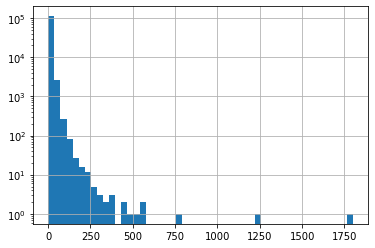

In [287]:
lengths_series.hist(bins=50, log=True)

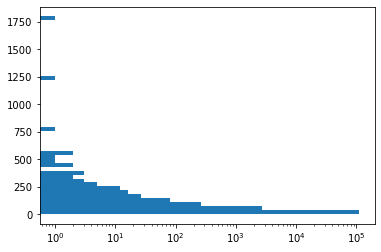

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame({
   'values': np.random.normal(100, 10, 5000)
})

# Plot a horizontal histogram with log scale
plt.hist(lengths_series, bins=50, log=True, orientation='horizontal')

plt.show()


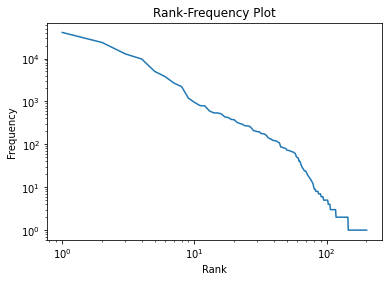

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = lengths_series

# Compute frequencies
frequencies = data.value_counts()

# Sort frequencies in descending order
sorted_freq = frequencies.sort_values(ascending=False)

# Generate rank data
ranks = np.arange(1, len(sorted_freq) + 1)

# Create a rank-frequency plot
plt.loglog(ranks, sorted_freq.values)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Rank-Frequency Plot')

plt.show()


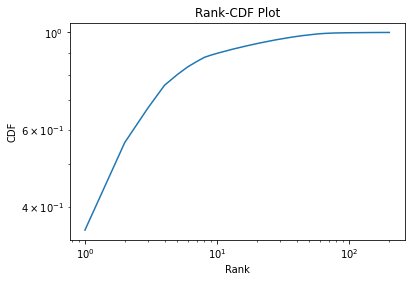

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = lengths_series

# Compute frequencies
frequencies = data.value_counts()

# Sort frequencies in descending order
sorted_freq = frequencies.sort_values(ascending=False)

# Compute cumulative frequencies
cumulative_freq = np.cumsum(sorted_freq.values)

# Normalize cumulative frequencies to get a CDF
cdf = cumulative_freq / cumulative_freq[-1]

# Generate rank data
ranks = np.arange(1, len(sorted_freq) + 1)

# Create a rank-cdf plot
plt.loglog(ranks, cdf)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('CDF')
plt.title('Rank-CDF Plot')

plt.show()


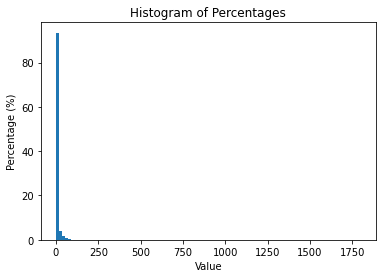

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame
data = lengths_series

# Number of bins
bins = 100

# Compute histogram
values, bin_edges = np.histogram(data, bins=bins)

# Convert counts to percentages
values = values / len(data) * 100

# Compute bin centers
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

# Plot histogram of percentages
plt.bar(bin_centers, values, width=(bin_edges[1] - bin_edges[0]))

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Percentage (%)')
plt.title('Histogram of Percentages')

plt.show()


In [2]:
lengths_series

NameError: name 'lengths_series' is not defined